In [1]:
# Import Dependencies
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy import stats
import seaborn as sns

# Store pathfile as a variable
raw_file = Path("C:\\Users\\leival\\Documents\\Reports\\randomized_patient_data.xlsx")

#Read raw file and convert to dataframe
df = pd.read_excel(raw_file)

#Clean up dataframe from dropping sensitive PHI information
# = drop unnecessary columns
df.drop(columns = ['LAST_NAME', 'PATIENT', 'DOB', 'GROUP_TEST_ID'], inplace = True)

# = rename columns
df = df.rename(columns= {'DIAG_CODE1' : 'DIAG_CODE'})

# = drop NaN values dataframe
df = df.dropna()

#drop age ranges over 100 since avg human lifespan does exceed 100
df = df.loc[df['AGE'] <= 100]

#Drop unknown (U) and patient declined (N) SEX values
df = df[~df['SEX'].isin(['U', 'N'])]

df

,MRN,AGE,SEX,ETHNICITY,VER_DATE,DIAG_CODE,TEST,RESULT
0,646919,10,M,H,2025-03-30,Y35,HCT,34
1,751482,64,M,N,2024-12-28,J1,HCT,34
2,223959,70,F,N,2024-11-02,K56,HCT,36
3,566650,31,M,U,2025-02-18,Q0,HCT,29
4,154677,70,M,D,2023-08-24,Y0,HCT,26
...,...,...,...,...,...,...,...,...
995,543395,34,M,D,2023-11-24,Z54,HGB,10
996,341595,14,F,H,2023-05-14,M7,HGB,5
997,328395,74,F,H,2024-02-17,B10,HGB,10
998,135297,48,M,U,2024-03-09,M39,HGB,6


In [2]:
# = Provide Categories for DIAG_CODE
# Define the code ranges and their categories
code_ranges = [
    ("A00", "B99", "Infectious Diseases"),
    ("C00", "D49", "Neoplasms"),
    ("D50", "D89", "Hematologic Disorders"),
    ("E00", "E89", "Metabolic Diseases"),
    ("F01", "F99", "Neurodevelopment Disorders"),
    ("G00", "G99", "Neurological Conditions"),
    ("H00", "H59", "Ocular Disorders"),
    ("H60", "H95", "Otologic Disorders"),
    ("I00", "I99", "Cardiovascular Disorders"),
    ("J00", "J99", "Respiratory Diseases"),
    ("K00", "K95", "Gastrointestinal Disorders"),
    ("L00", "L99", "Dermatologic Disorders"),
    ("M00", "M99", "Musculoskeletal Diseases"),
    ("N00", "N99", "Urogenital Disorders"),
    ("O00", "O9A", "Obstetric Conditions"),
    ("P00", "P96", "Perinatal Disorders"),
    ("Q00", "Q99", "Congenital Anomalies"),
    ("R00", "R99", "Laboratory Findings"),
    ("S00", "T88", "External Injuries"),
    ("U00", "U85", "Special Condition"),
    ("V00", "Y99", "External Morbidity"),
    ("Z00", "Z99", "Health Influencing Factors")
]

def get_category(code):
    # Extract the alphanumeric part without the dot
    cleaned_code = code.split('.')[0]  # e.g., 'Z00.121' -> 'Z00'
    
    for start, end, category in code_ranges:
        if start <= cleaned_code <= end:
            return category
    return "NaN"

# Create a new column with DIAG Desc category
df['DIAG_DESC'] = df['DIAG_CODE'].apply(get_category)

df

,MRN,AGE,SEX,ETHNICITY,VER_DATE,DIAG_CODE,TEST,RESULT,DIAG_DESC
0,646919,10,M,H,2025-03-30,Y35,HCT,34,External Morbidity
1,751482,64,M,N,2024-12-28,J1,HCT,34,Respiratory Diseases
2,223959,70,F,N,2024-11-02,K56,HCT,36,Gastrointestinal Disorders
3,566650,31,M,U,2025-02-18,Q0,HCT,29,NaN
4,154677,70,M,D,2023-08-24,Y0,HCT,26,External Morbidity
...,...,...,...,...,...,...,...,...,...
995,543395,34,M,D,2023-11-24,Z54,HGB,10,Health Influencing Factors
996,341595,14,F,H,2023-05-14,M7,HGB,5,Musculoskeletal Diseases
997,328395,74,F,H,2024-02-17,B10,HGB,10,Infectious Diseases
998,135297,48,M,U,2024-03-09,M39,HGB,6,Musculoskeletal Diseases


In [3]:
#Create a table of average HCT and HGB values per patient
#Convert Result column to numeric
df['RESULT'] = pd.to_numeric(df['RESULT'], errors='coerce')

#Creating pivot table with functions transpose and reset index
df_avg = df.pivot_table(index=['TEST'], columns=['MRN'], values='RESULT', aggfunc='mean').transpose().reset_index()

#Formula for HCT/Hgb Ratio
df_avg['HCT/HGB Ratio'] = ((df_avg['HCT'] / df_avg['HGB'])).round(2)

#remove inf values
df_avg.replace([np.inf, -np.inf], np.nan, inplace=True)

df_avg.dropna()

TEST,MRN,HCT,HGB,HCT/HGB Ratio
0,102138,24.0,5.0,4.80
1,109278,23.0,6.0,3.83
2,110581,22.0,7.0,3.14
3,113111,20.0,10.0,2.00
4,115859,28.0,8.0,3.50
...,...,...,...,...
494,997779,28.0,8.0,3.50
495,998445,29.0,6.0,4.83
496,998979,29.0,8.0,3.62
497,999157,28.0,9.0,3.11


In [4]:
# Utilizing merge, drop duplicates, & dropna to provide a clean combined dataset
df_final = df_avg.merge(df[['MRN','AGE','SEX','ETHNICITY','DIAG_DESC']], on='MRN', how='left').drop(columns='MRN').drop_duplicates().dropna()

# For age ranges, define custom bins and labels
bins= [0,10,20,50,100]
labels = ['0-10','11-20','21-50','51-100']

# Create a column that shows how the age is grouped together
df_final['AGE_BIN'] = pd.cut(df_final['AGE'], bins=bins, labels=labels, right=True)

print(len(df_final))
df_final

979


,HCT,HGB,HCT/HGB Ratio,AGE,SEX,ETHNICITY,DIAG_DESC,AGE_BIN
0,24.0,5.0,4.80,66,F,H,External Morbidity,51-100
1,24.0,5.0,4.80,66,F,H,Infectious Diseases,51-100
2,23.0,6.0,3.83,44,F,N,Urogenital Disorders,21-50
3,23.0,6.0,3.83,44,F,N,Neurodevelopment Disorders,21-50
4,22.0,7.0,3.14,41,F,N,External Injuries,21-50
...,...,...,...,...,...,...,...,...
995,29.0,8.0,3.62,35,M,H,External Morbidity,21-50
996,28.0,9.0,3.11,56,M,U,Metabolic Diseases,51-100
997,28.0,9.0,3.11,56,M,U,External Injuries,51-100
998,25.0,14.0,1.79,9,F,H,Cardiovascular Disorders,0-10


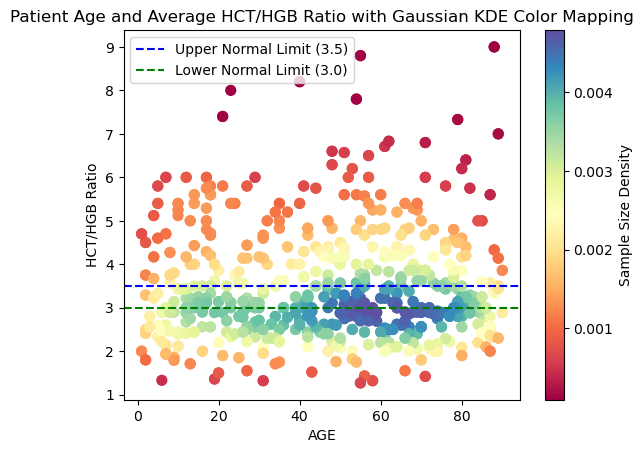

In [5]:
# Stack 'AGE' and 'HCT/HGB Ratio' columns into a 2D array for KDE calculation
xy = np.vstack([df_final['AGE'], df_final['HCT/HGB Ratio']])

#Compute the KDE
# = KDE: Gaussian Kernel Density Estimation (KDE) is a non-parametric way to estimate the probability density function (PDF) of a random variable.
kde = gaussian_kde(xy)
z = kde(xy)

#Plot the data
fig, ax = plt.subplots()
sc = ax.scatter(df_final['AGE'], df_final['HCT/HGB Ratio'], c=z, s=50, cmap='Spectral')
plt.colorbar(sc, ax=ax, label='Sample Size Density')

# Add horizontal lines for normal ratio range
ax.axhline(y=3.5, color='blue', linestyle='--', linewidth=1.5, label='Upper Normal Limit (3.5)')
ax.axhline(y=3, color='green', linestyle='--', linewidth=1.5, label='Lower Normal Limit (3.0)')


#Adding labels to plot
ax.set_xlabel('AGE')
ax.set_ylabel('HCT/HGB Ratio')
ax.set_title('Patient Age and Average HCT/HGB Ratio with Gaussian KDE Color Mapping')
ax.legend()
plt.show()

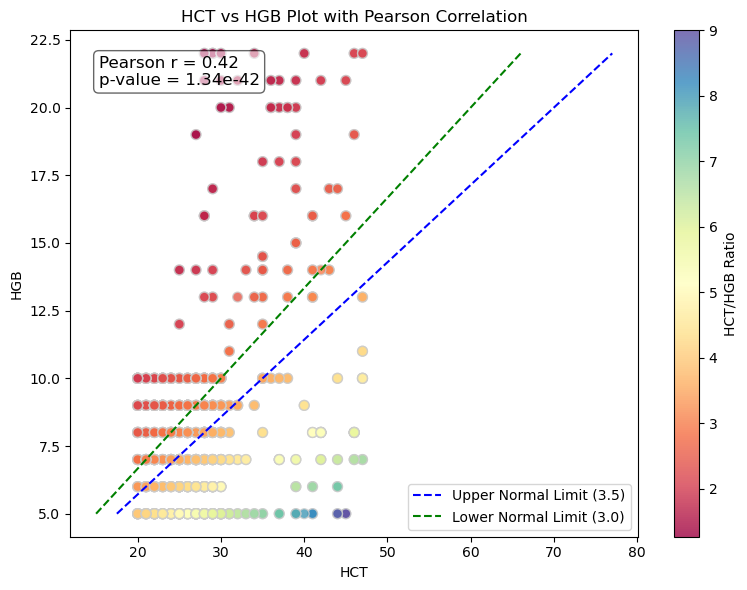

In [6]:
#Calculating the pearson value amongst HCT and HBG
pearson_result = stats.pearsonr(df_final['HCT'],df_final['HGB'], alternative='two-sided')
corr_coef, p_value = pearson_result
#print(f"Correlation: {corr_coef:.3f}, p-value: {p_value:.3e}")

# Plot scatter
plt.figure(figsize=(8, 6))
sc = plt.scatter(df_final['HCT'], df_final['HGB'], c=df_final['HCT/HGB Ratio'], alpha=0.8, edgecolor='0.8', s=50, cmap='Spectral')

# Add regression line
slope, intercept, *_ = stats.linregress(df_final['HCT'], df_final['HGB'])
x_vals = np.array([df_final['HCT'].min(), df_final['HCT'].max()])
y_vals = intercept + slope * x_vals
#plt.plot(x_vals, y_vals, color='red', label=f'Regression Line')

# Annotate with Pearson r and p-value
plt.text(
    0.05, 0.95,
    f"Pearson r = {corr_coef:.2f}\np-value = {p_value:.2e}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Colorbar for 
cbar = plt.colorbar(sc)
cbar.set_label('HCT/HGB Ratio')

# Define range of HGB values for plotting lines
hgb_range = np.linspace(df_final['HGB'].min(), df_final['HGB'].max(), 100)

# Calculate corresponding HCT values for ratio thresholds
lower_limit = 3.0 * hgb_range
upper_limit = 3.5 * hgb_range

# Plot the lines
plt.plot(upper_limit, hgb_range, color='blue', linestyle='--', label='Upper Normal Limit (3.5)')
plt.plot(lower_limit, hgb_range, color='green', linestyle='--', label='Lower Normal Limit (3.0)')

# Labels and title
plt.xlabel('HCT')
plt.ylabel('HGB')
plt.title('HCT vs HGB Plot with Pearson Correlation')
plt.legend()
plt.tight_layout()
plt.show()

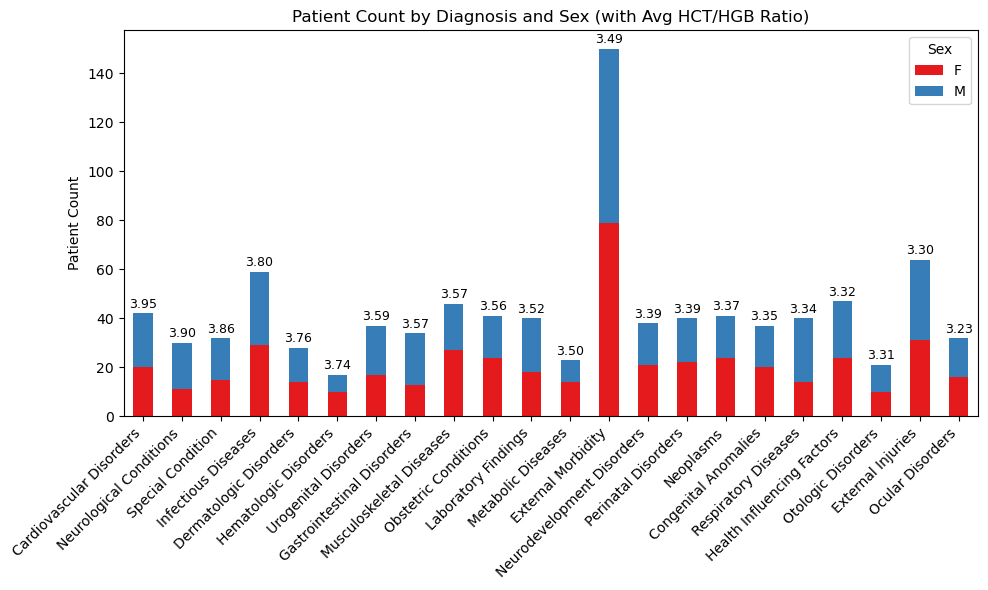

In [7]:
#Group based on DIAG_DESC
diag = df_final.groupby('DIAG_DESC')['HCT/HGB Ratio'].mean().reset_index()
diag['DIAG_DESC'] = diag['DIAG_DESC'].replace('NaN', np.nan)
diag = diag.dropna(subset=['DIAG_DESC'])

#Group to get sex information based on 'DIAG_DESC'
sex_counts = df_final.groupby(['DIAG_DESC', 'SEX']).size().reset_index(name='count')

#Merge HCT/HGB ratio with sex counts
merged = pd.merge(sex_counts, diag, on='DIAG_DESC', how='inner')

# Pivot for stacked bar
pivot = sex_counts.pivot(index='DIAG_DESC', columns='SEX', values='count').fillna(0)

# Merge with ratios
pivot_with_ratio = pivot.merge(diag, on='DIAG_DESC').sort_values('HCT/HGB Ratio', ascending=False)

#Define a color palette (e.g., 'Set2' or 'Blues')
palette = sns.color_palette('Set1')

# Plot
ax = pivot_with_ratio[['F', 'M']].plot(kind='bar', stacked=True, figsize=(10, 6), color=palette)

# Add HCT/HGB ratio as text on each bar
for i, ratio in enumerate(pivot_with_ratio['HCT/HGB Ratio']):
    ax.text(i, pivot_with_ratio[['F', 'M']].iloc[i].sum() + 1,  # position on top of bar
            f'{ratio:.2f}', ha='center', va='bottom', fontsize=9, color='black')



plt.ylabel('Patient Count')
plt.title('Patient Count by Diagnosis and Sex (with Avg HCT/HGB Ratio)')
plt.xticks(ticks=range(len(pivot_with_ratio)), labels=pivot_with_ratio['DIAG_DESC'], rotation=45, ha='right')
plt.legend(title='Sex')
plt.tight_layout()
plt.show()

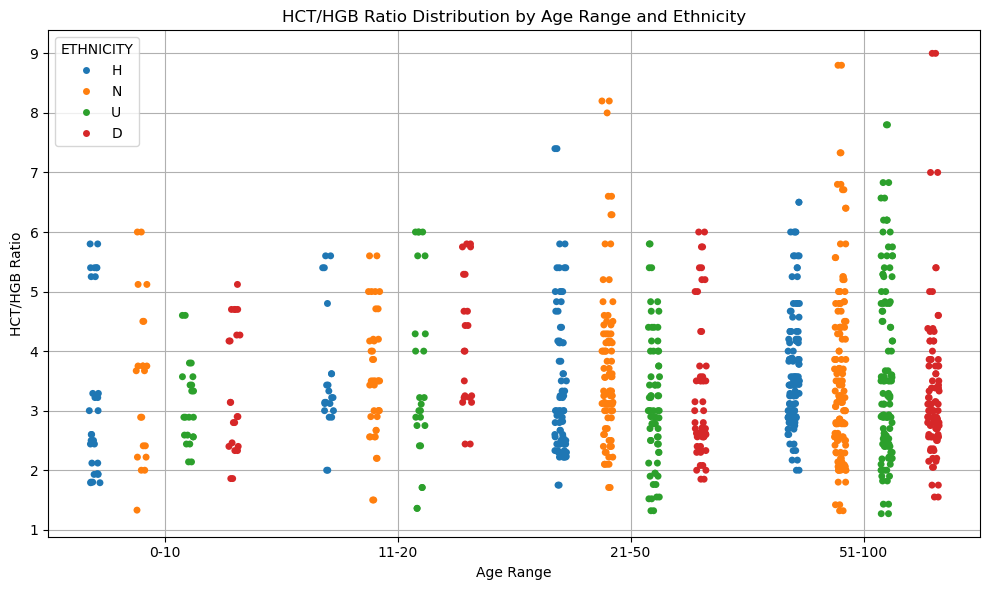

In [8]:
# Stripplot to see the distribution of HCT/HGB Ratio by Age_Bin and ETHNICITY
plt.figure(figsize=(10, 6))
sns.stripplot(x='AGE_BIN', y='HCT/HGB Ratio', hue='ETHNICITY', data=df_final, dodge=True, jitter=True, marker='o')
plt.title('HCT/HGB Ratio Distribution by Age Range and Ethnicity')
plt.xlabel('Age Range')
plt.ylabel('HCT/HGB Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

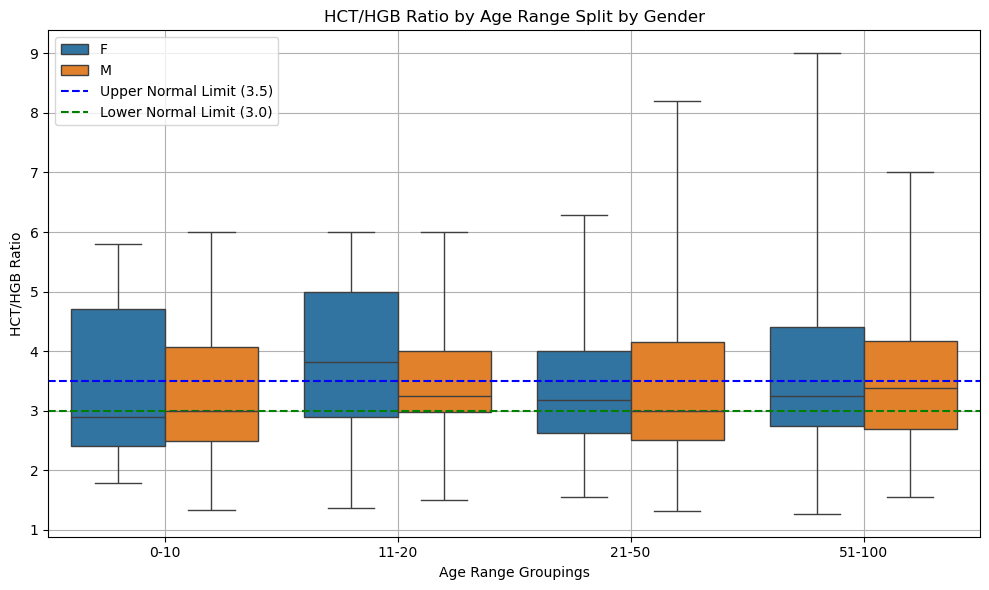

In [9]:
# Set up the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='AGE_BIN', y='HCT/HGB Ratio', data=df_final, hue='SEX', whis=(0, 100))

# Add horizontal lines for normal ratio range
ax.axhline(y=3.5, color='blue', linestyle='--', linewidth=1.5, label='Upper Normal Limit (3.5)')
ax.axhline(y=3, color='green', linestyle='--', linewidth=1.5, label='Lower Normal Limit (3.0)')

# Customize
plt.title('HCT/HGB Ratio by Age Range Split by Gender')
plt.xlabel('Age Range Groupings')
plt.ylabel('HCT/HGB Ratio')
plt.grid(True)
plt.legend()  # Add legend to show the label for the lines
plt.tight_layout()

# Show the plot
plt.show()
